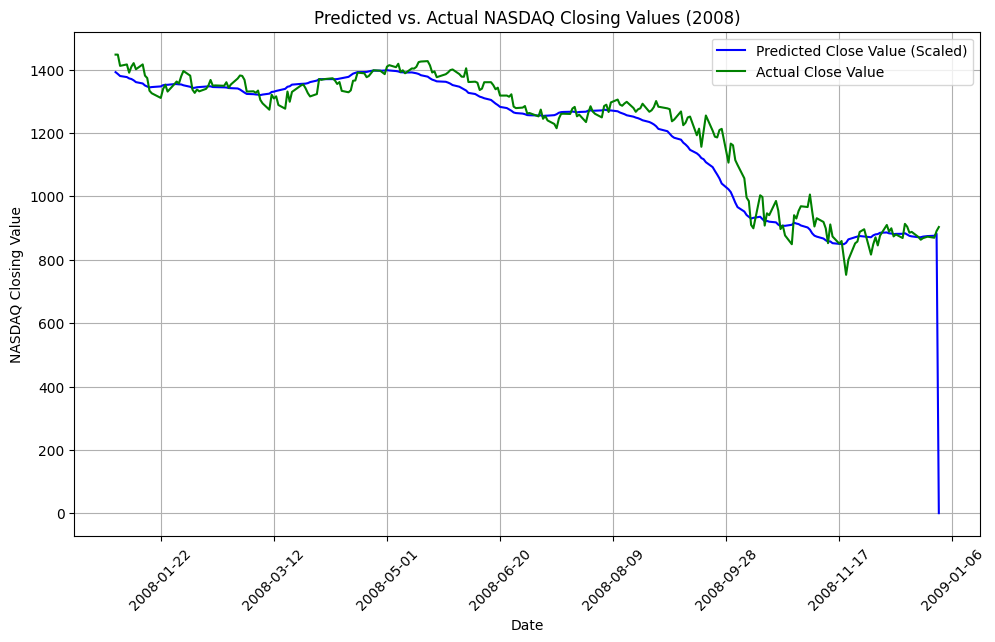

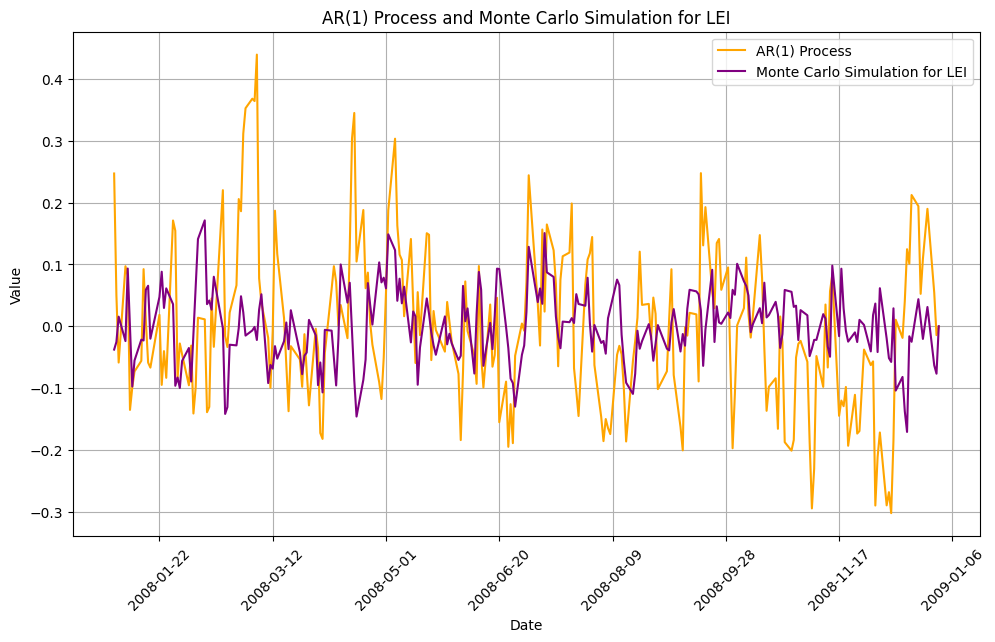

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class KalmanFilter:
    def __init__(self, beta_initial, P_initial, Q, R):
        self.beta = beta_initial  # Initial guess for beta
        self.P = P_initial        # Initial covariance matrix
        self.Q = Q                # Process noise covariance
        self.R = R                # Measurement noise covariance

    def update(self, y):
        # Prediction
        beta_predicted = self.beta
        P_predicted = self.P + self.Q

        # Update
        K = P_predicted / (P_predicted + self.R)
        self.beta = beta_predicted + K * (y - beta_predicted)
        self.P = (1 - K) * P_predicted

        return self.beta

# Load NASDAQ data from CSV file
nasdaq_data = pd.read_csv("/Users/dobromiriliev/Documents/GitHub/MonteCarlo2008Simulation/NasdaqData.csv")

# Remove commas from the 'Close' column and convert to float
nasdaq_data['Close'] = nasdaq_data['Close'].str.replace(',', '').astype(float)

# Convert 'Date' column to datetime
nasdaq_data['Date'] = pd.to_datetime(nasdaq_data['Date'])

# Filter NASDAQ data for the year 2008
nasdaq_data_2008 = nasdaq_data[(nasdaq_data['Date'] >= '2008-01-01') & (nasdaq_data['Date'] <= '2008-12-31')]

# Extract relevant columns
nasdaq_dates = nasdaq_data_2008['Date']
nasdaq_close = nasdaq_data_2008['Close']

# Parameters for Kalman filter and AR(1) process
rho = 0.7              # True autocorrelation coefficient
sigma = 0.1            # Std dev of epsilon
Q = 0.0001             # Process noise covariance
R = 0.01               # Measurement noise covariance

# Simulate AR(1) process
np.random.seed(42)
T = len(nasdaq_close)
W = np.random.normal(loc=0, scale=sigma, size=T)
W = W - np.mean(W)  # Remove the mean
X_ar = np.zeros(T)
for i in range(T - 1):
    X_ar[i + 1] = rho * X_ar[i] + W[i + 1]

# Monte Carlo Simulation for Leading Economic Indicators
# Parameters for the leading economic indicator simulation
LEI_rho = 0.5        # Autocorrelation coefficient for the leading indicator
LEI_sigma = 0.05     # Standard deviation of the noise for the leading indicator
LEI_Q = 0.0001       # Process noise covariance for the leading indicator

# Simulate the leading economic indicator (LEI)
LEI_T = T  # Use the same length as NASDAQ data
LEI_W = np.random.normal(loc=0, scale=LEI_sigma, size=LEI_T)
LEI_W = LEI_W - np.mean(LEI_W)  # Remove the mean
LEI_X_ar = np.zeros(LEI_T)
for i in range(LEI_T - 1):
    LEI_X_ar[i + 1] = LEI_rho * LEI_X_ar[i] + LEI_W[i + 1]

# Combine the LEI with NASDAQ data for the simulation
combined_indicator = 0.5 * LEI_X_ar + 0.5 * X_ar  # Weighted combination

# Initialize Kalman filter
beta_initial = 0.5  # Initial guess for beta
P_initial = 1       # Initial covariance matrix
kalman_filter = KalmanFilter(beta_initial, P_initial, Q, R)

# Tracking the hidden variable using NASDAQ close prices for the year 2008
estimated_betas = []
predicted_close_values = []
actual_close_values = nasdaq_close.values

# Initialize with the first value
beta_estimate = beta_initial
predicted_close_values.append(beta_estimate)

# Predict for subsequent values
for i in range(1, T):
    beta_estimate = kalman_filter.update(actual_close_values[i])  # Update using the current close value
    estimated_betas.append(beta_estimate)
    predicted_close_value = beta_estimate  # Use the current close value and scale
    predicted_close_values.append(predicted_close_value)

# Plotting actual vs predicted results
plt.figure(figsize=(10, 6))
plt.plot(nasdaq_dates, predicted_close_values, label='Predicted Close Value', color='blue')
plt.plot(nasdaq_dates, actual_close_values, label='Actual Close Value', color='green')
plt.xlabel('Date')
plt.ylabel('NASDAQ Closing Value')
plt.title('Predicted vs. Actual NASDAQ Closing Values (2008)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Set maximum number of x-axis labels to display
plt.show()

# Plotting Kalman filter prediction, AR(1) process, and Monte Carlo simulation for LEI separately
plt.figure(figsize=(10, 6))

# Plot AR(1) process
plt.plot(nasdaq_dates, X_ar, label='AR(1) Process', color='orange')

# Plot Monte Carlo Simulation for Leading Economic Indicators
plt.plot(nasdaq_dates, LEI_X_ar, label='Monte Carlo Simulation for LEI', color='purple')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('AR(1) Process and Monte Carlo Simulation for LEI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Set maximum number of x-axis labels to display
plt.show()